@swillner this is my attempt to see how OpenSCM's timeframes work from the user perspective. Let's use it as a discussion board.

In [1]:
import numpy as np
from itertools import count
from matplotlib import pyplot as plt
from copy import copy
from openscm import timeframes

<IPython.core.display.Javascript object>

## Example 1: CO$_2$ Concentration Data

Consider a timeframe of 5 points representing, say, CO$_2$ concentration data.

In [2]:
# original CO2 conc data
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_time_period = 1
source_time_start = 1
source_times = np.linspace(
    source_time_start, 
    source_time_start + source_time_period*(len(source_values)-1), 
    len(source_values)
) 

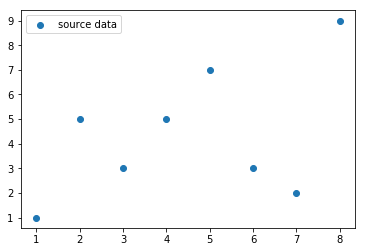

In [3]:
ax = plt.figure().add_subplot(111)
ax.scatter(source_times, source_values, label="source data", marker="o")
ax.legend();

Now let's say that we want to interpolate this data onto a grid with a timestep which is half as small

In [4]:
target_times = np.linspace(
    source_times[0], 
    source_times[-1], 
    2*len(source_values) - 1  # sit on end point exactly
) 

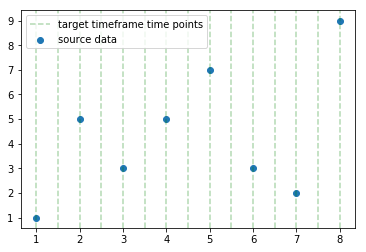

In [5]:
ax = plt.figure().add_subplot(111)
ax.scatter(source_times, source_values, label="source data", marker="o")
for i, x in enumerate(target_times):
    ax.axvline(
        x=x, 
        color="green", 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.legend(loc="upper left");

OpenSCM should be able to do this, but currently cannot, for reasons I don't understand.

In [6]:
source = timeframes.Timeframe(
    start_time=source_time_start,
    period_length=source_time_period
)
target = timeframes.Timeframe(
    start_time=source_time_start,
    period_length=source_time_period*0.5
)
target_values = timeframes._convert(
    source_values,
    source,
    target
)
target_values

object of type <class 'float'> cannot be safely interpreted as an integer.
invalid value encountered in double_scalars
divide by zero encountered in true_divide
divide by zero encountered in double_scalars


array([nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf])

Putting that OpenSCM behaviour aside, when doing such an interpolation there are choices to be made. I think the most common cases depend on three different things:

- whether you are doing interpolation only or also require extrapolation
    - for interpolation you have to think about what kind of spline you want to use (also depends on whether you need to preserve the integral or not)
    - for extrapolation you need to think about the kind of spline and how you extend it outside your data domain
- whether you are downscaling or upscaling
    - the spline you use may change depending on which way you're going (upscaling a moving average may be better, downscaling a spline may be better)
- whether you need to preserve the integral of your data or not
    - your spline will change depending on the answer

This gives us 8 possible outcomes (3 questions, 2 options per question). At the moment we are always assuming that we are in one of two cases: interpolation, integral preserving and down/upscaling. I think this is an error.

As a result, I am not sure that we want to make any assumptions internally in OpenSCM. Regridding is always tricky and the user should confirm that it is going to behave as desired before moving on. I do think we should have a notebook which illustrates each of the major cases and shows how to do it in OpenSCM, it just should always be a user/adapter choice to do any of these operations, it shouldn't be automatic.   